In [34]:
from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split
import click
from rra_tools import jobmon
from pymer4.models.Lmer import Lmer
import seaborn as sns
import matplotlib.pyplot as plt

from spatial_temp_cgf import cli_options as clio
from spatial_temp_cgf import binning, scaling
from spatial_temp_cgf.data import DEFAULT_ROOT, ClimateMalnutritionData
from spatial_temp_cgf.model_specification import (
    ModelSpecification,
)

from spatial_temp_cgf.training.run_training import prepare_model_data

In [2]:
def prepare_model_version(model_specification_path):
    output_root = DEFAULT_ROOT

    # Build version and save spec
    model_spec = ModelSpecification.from_yaml(model_specification_path)
    measure = model_spec.measure
    measure_root = Path(output_root) / measure
    cm_data = ClimateMalnutritionData(measure_root)
    model_version = cm_data.new_model_version()
    model_spec.version.model = model_version
    cm_data.save_model_specification(model_spec, model_version)
    return model_version

# Prepare a test version.  Only need to run once to do testing
model_spec_path = "../specifications/stunting_test.yaml"
prepare_model_version(model_spec_path)

'2024_07_01.09'

In [ ]:
ds = xr.open_dataset('/mnt/team/rapidresponse/pub/population/modeling/climate_malnutrition/input/srtm_elevation.tif')
elevation = ds.sel(x=xr.DataArray(full_training_data.long, dims='z'), y=xr.DataArray(full_training_data.lat, dims='z'), method='nearest').band_data.to_dataframe()

In [3]:
output_root = Path(DEFAULT_ROOT)
measure = 'stunting'
model_version = '2024_07_01.06'
age_group_id = 5
sex_id = 1

In [47]:
cm_data = ClimateMalnutritionData(output_root / measure)
model_spec = cm_data.load_model_specification(model_version)

# Load training data
full_training_data = cm_data.load_training_data(model_spec.version.training_data)
# FIXME: Prep leaves a bad index
full_training_data = full_training_data.reset_index(drop=True)    
full_training_data['intercept'] = 1.

ds = xr.open_dataset('/mnt/team/rapidresponse/pub/population/modeling/climate_malnutrition/input/srtm_elevation.tif')
elevation = ds.sel(x=xr.DataArray(full_training_data.long, dims='z'), y=xr.DataArray(full_training_data.lat, dims='z'), method='nearest').band_data.to_dataframe()
full_training_data['elevation'] = elevation['band_data'].fillna(0).values

subset_mask = (
    (full_training_data.sex_id == sex_id) 
    & (full_training_data.age_group_id == age_group_id)
)

raw_df = full_training_data.loc[:, model_spec.raw_variables + ['elevation', "mean_temperature"]]   
null_mask = raw_df.isnull().any(axis=1)
assert null_mask.sum() == 0

df, var_info = prepare_model_data(raw_df, model_spec)

raw_df = raw_df.loc[subset_mask].reset_index(drop=True)
df = df.loc[subset_mask].reset_index(drop=True)



<Axes: >

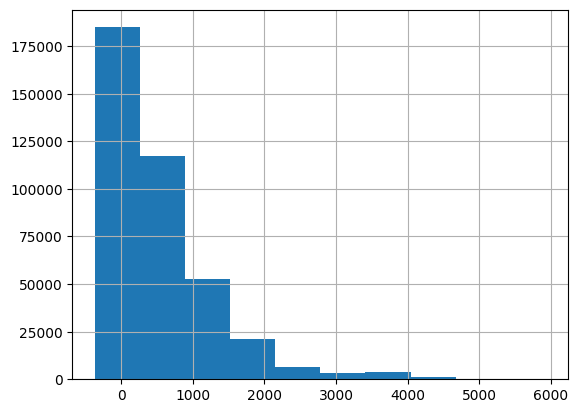

In [56]:
raw_df.elevation.hist()

In [48]:
# TODO: Test/train split
df['any_days_over_30C'] = (df['days_over_30C'] > 0).astype(float)
df['elevation'] = raw_df['elevation'] / raw_df['elevation'].max()
df["mean_temperature"] =  (raw_df['mean_temperature'] - raw_df['mean_temperature'].min()) / (raw_df['mean_temperature'].max() - raw_df['mean_temperature'].min())
formula = "stunting ~ (1 | ihme_loc_id) + days_over_30C + ldi_pc_pd + elevation + any_days_over_30C * ldi_pc_pd + mean_temperature"
model = Lmer(formula, data=df, family='binomial')
model.fit()
if len(model.warnings) > 0:
    # TODO save these to a file
    print(model.warnings)
    raise ValueError(f"Model {model_spec} did not fit.")
model.var_info = var_info
model.raw_data = raw_df


Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: stunting~(1|ihme_loc_id)+days_over_30C+ldi_pc_pd+elevation+any_days_over_30C*ldi_pc_pd+mean_temperature

Family: binomial	 Inference: parametric

Number of observations: 391086	 Groups: {'ihme_loc_id': 54.0}

Log-likelihood: -250008.692 	 AIC: 500033.383

Random effects:

                    Name   Var    Std
ihme_loc_id  (Intercept)  0.21  0.458

No random effect correlations specified

Fixed effects:



In [45]:
def describe_model(m, fig_title):
    print(m.coefs['Estimate'])
    df = model.data.copy()
    df['over_30'] = pd.cut(df.days_over_30C * 366, [0, 1, 2, 7, 15, 30, 60, 90, 180, 367], right=False)
    df['ldi']  = pd.qcut(df.ldi_pc_pd, 10)
    df['pred'] = m.predict(m.design_matrix, use_rfx=False, verify_predictions=False)

    fig, axes = plt.subplots(figsize=(20, 5), ncols=3)
    
    sns.heatmap(df.groupby(['ldi', 'over_30']).stunting.mean().unstack(), cmap='RdYlBu_r', ax=axes[0])
    axes[0].set_title('Data')
    sns.heatmap(df.groupby(['ldi', 'over_30']).fits.mean().unstack(), cmap='RdYlBu_r', ax=axes[1])
    axes[1].set_title('With location random effects')
    sns.heatmap(df.groupby(['ldi', 'over_30']).pred.mean().unstack(), cmap='RdYlBu_r', ax=axes[2])
    axes[2].set_title('Without location random effects')

    fig.suptitle(fig_title, fontsize=18)
    fig.tight_layout()
    plt.show()
    



(Intercept)                    -0.311435
days_over_30C                   0.548673
ldi_pc_pd                     -10.413498
elevation                       1.335106
any_days_over_30C               0.019335
ldi_pc_pd:any_days_over_30C     3.689517
Name: Estimate, dtype: float64


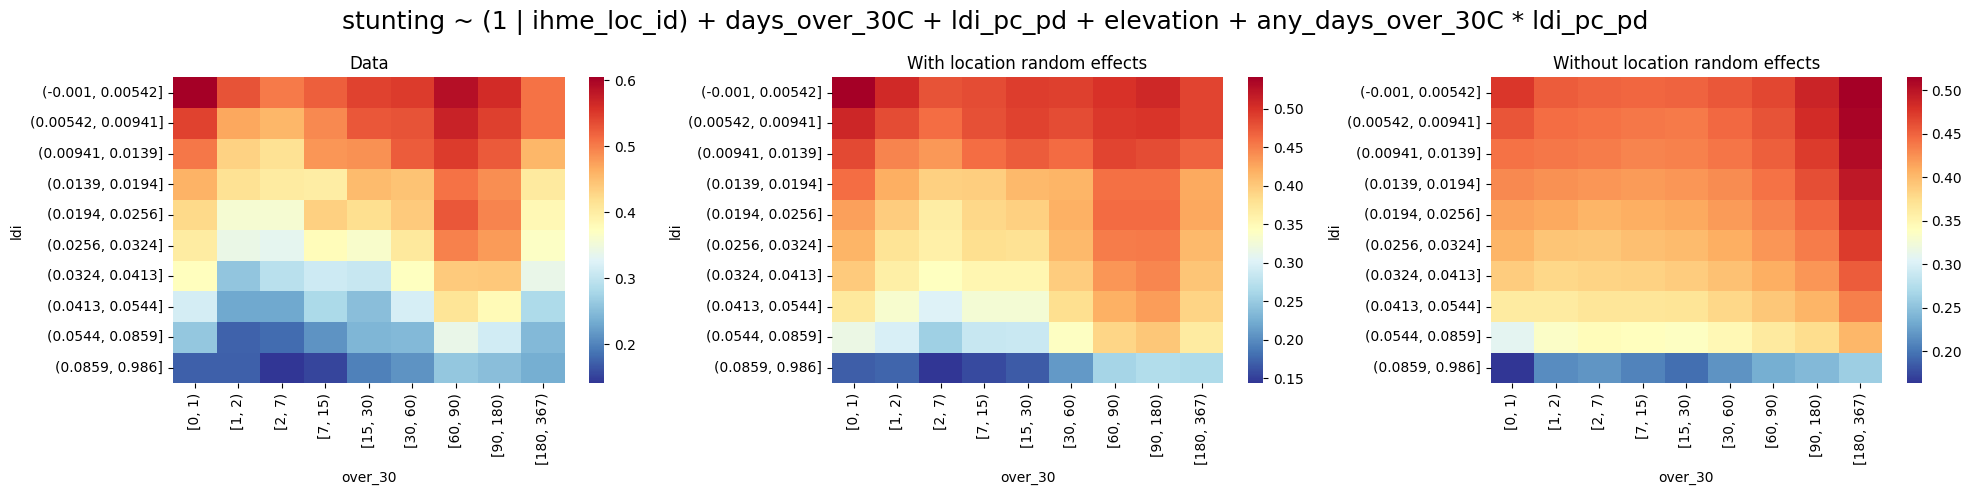

In [46]:
describe_model(model, formula)

(Intercept)                    -0.693798
days_over_30C                   0.480396
ldi_pc_pd                     -10.360069
elevation                       1.638721
any_days_over_30C               0.007972
mean_temperature                0.457452
ldi_pc_pd:any_days_over_30C     3.633440
Name: Estimate, dtype: float64


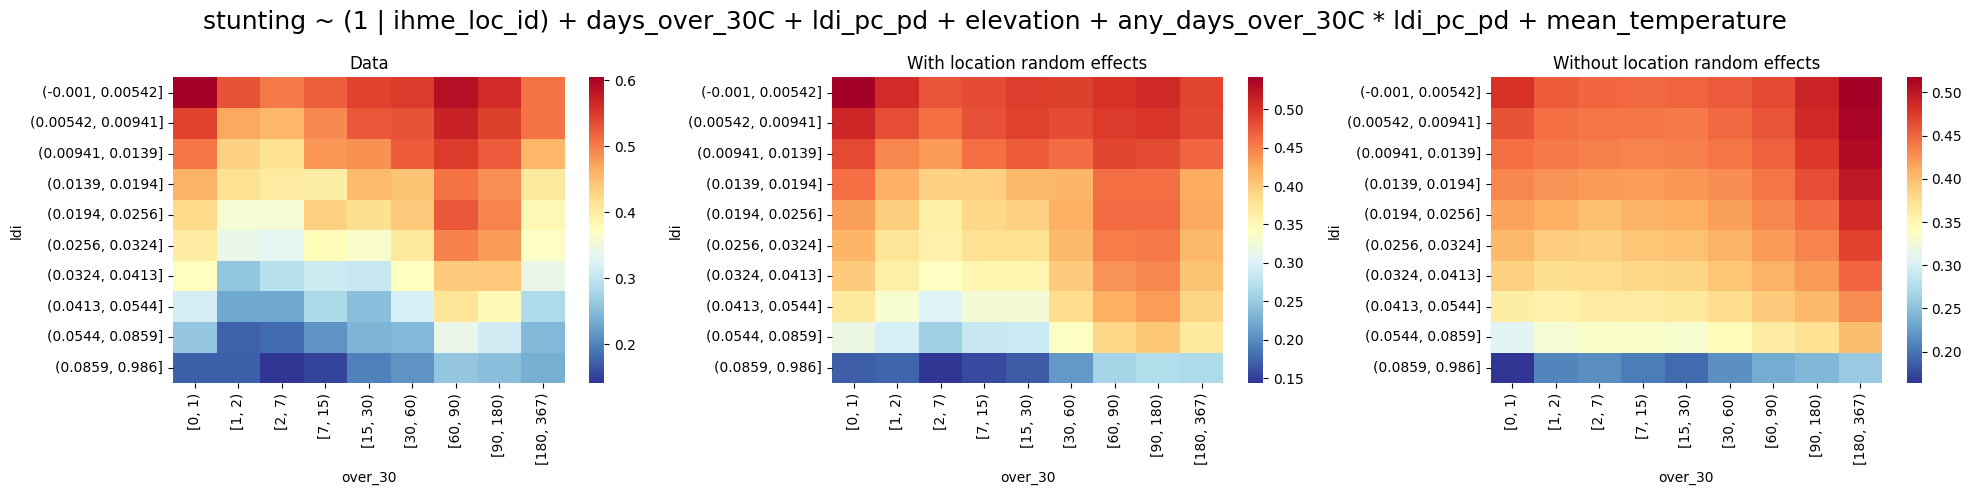

In [49]:
describe_model(model, formula)

In [52]:
model.ranef.mean()

X.Intercept.    0.000275
dtype: float64

In [8]:
import pickle
from pathlib import Path

p = Path('/mnt/team/rapidresponse/pub/population/modeling/climate_malnutrition/stunting/models/2024_07_01.05/5_1.pkl')
with p.open('rb') as f:
    m = pickle.load(f)

df = m.data

In [ ]:
m.ranef[0]

In [ ]:
res = m.ranef[0].reset_index().rename(columns={'index': 'grid_cell'})
res['ldi'] = res['grid_cell'].apply(lambda x: float(x.split("_")[0].split(",")[0][1:]))
res['temp'] = res['grid_cell'].apply(lambda x: float(x.split("_")[1].split(",")[0][1:]))

In [ ]:
sns.heatmap(res.set_index(['ldi', 'temp'])['X.Intercept.'].unstack(), cmap='RdYlBu_r')

In [ ]:
m.var_info['grid_cell']['coefs'].sort_values('grid_cell')

In [ ]:
x = raw_df[raw_df.mean_temperature > 28]
x['ldi_bin'] = pd.qcut(x.ldi_pc_pd, 10)
x.groupby('ldi_bin').stunting.mean()

In [ ]:
raw_df[raw_df.ihme_loc_id == 'MLI'].stunting.mean()

In [ ]:
r = raw_df.combine_first(model.data)

In [ ]:
full_training_data

In [ ]:
r['pred_no_loc'] = model.predict(model.data, use_rfx=False, skip_data_checks=True, verify_predictions=False)

In [ ]:
r[r.ihme_loc_id == 'MLI'].mean()

In [ ]:
sns.heatmap(r.groupby(['ldi_bin', 'temp_bin']).pred_no_loc.mean().unstack(), cmap='RdYlBu_r')

In [ ]:
raw_df['ldi_bin'] = pd.cut(raw_df.ldi_pc_pd, sorted(df.ldi.unique()) + [500], right=False)
raw_df['temp_bin'] = pd.cut(raw_df.mean_temperature, sorted(df.temp.unique()) + [500], right=False)
sns.heatmap(raw_df.groupby(['ldi_bin', 'temp_bin']).stunting.mean().unstack(), cmap='RdYlBu_r')

In [ ]:
c = x.groupby('ihme_loc_id').stunting.count()
c = c / c.sum()
pd.concat([c.rename('data_proportion'), model.ranef.loc[c.index]], axis=1).sort_values('data_proportion')

In [ ]:
cc = raw_df.groupby('ihme_loc_id').stunting.count()
cc = cc / cc.sum()
cc

In [ ]:
df = m.data


In [9]:
df['ldi'] = df['grid_cell'].apply(lambda s: s.split("_")[0].split(',')[0][1:]).astype(float)
df['temp'] = df['grid_cell'].apply(lambda s: s.split("_")[1].split(',')[0][1:]).astype(float)

KeyError: 'grid_cell'

In [ ]:
import matplotlib.pyplot as plt
sns.scatterplot(data=df, x='mean_temperature', y='fits', hue='ldi_pc_pd', alpha=0.5)



In [ ]:
sns.scatterplot(data=df, x='ldi_pc_pd', y='residuals', hue='mean_temperature', alpha=0.5)

In [ ]:
df

In [ ]:
plt.scatter(df.mean_temperature, df.stunting + 0.05 * np.random.random(len(df)), alpha=0.05, s=1)

In [ ]:
sns.heatmap(df.groupby(['ldi', 'temp']).stunting.mean().unstack().sort_index(), cmap='RdYlBu_r')

In [ ]:
sns.heatmap(df.groupby(['ldi', 'temp']).fits.mean().unstack(), cmap='RdYlBu_r', vmax=0.3, vmin=0.15)

In [ ]:
df.grid_cell.unique()

In [ ]:
rdf = raw_df.combine_first(model.data)



In [ ]:
model.data

In [ ]:
fit = m.predict(df, verify_predictions=False)

In [ ]:
df['pred'] = (df['fits'] > 0.5).astype(int)

In [ ]:
df['residuals'].hist()

In [ ]:
df[df.stunting == 0].fits.hist(bins=100)

In [ ]:
df[df.stunting == 1].fits.hist()

In [ ]:
df = model.data 
df[df.stunting == 0].residuals.hist()

In [ ]:
df[df.stunting == 1].residuals.hist()

In [ ]:
import numpy as np
size = 5000
x = pd.DataFrame({
    'temp': np.linspace(5, 50, size),
    'ldi_pc_pd': np.linspace(0, 500, size),
    'ihme_loc_id': np.nan * np.ones(size),
    'intercept': np.ones(size),
})

for predictor in model_spec.predictors:
    x, _ = scaling.scale_column(x, predictor.name, predictor.transform, var_info[predictor.name])



In [ ]:
x

In [ ]:
model.predict(x, skip_data_checks=True, verify_predictions=False)

In [ ]:
var_info

In [ ]:
raw_df[(raw_df.ldi_pc_pd < 0.95) & (raw_df.mean_temperature < 17.56)].stunting.mean()

In [ ]:
"/mnt/team/integrated_analytics/pub/goalkeepers/goalkeepers_2024/"